#Test 5.7 (Data ingest), 5.9 and 5.4
Each of these tests uses a synthetic image that we generate as a 2D Gauss kernel array. 

## Test 5.7
Ingest an array of data and verify that the internal array is the same.

In [1]:
# Import eoldas_ng from the OPTIRAD suite and some additional python functions
import eoldas_ng
import numpy as np
import scipy.sparse as sp
from collections import OrderedDict
import random
import math

In [2]:
#Imports to allow plotting.
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define functions to generate an input image as an array.
def gauss_kern(size, sizey=None):
    """ 
    Returns a normalized 2D gauss kernel array for convolutions 
    From http://www.scipy.org/Cookbook/SignalSmooth
    """
    import numpy as np
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()
def create_data ( nr,nc,n_per=1, noise=0.15, obs_off=0.1, \
                                        window_size=5):
    """
    Create synthetic "NDVI-like" data for a fictitious space series. We return
    the original data, noisy data (using IID Gaussian noise), the QA flag as well
    as the time axis.
    
    Missing observations are simulated by drawing a random number between 0 and 1
    and checking against obs_off.
    
    Parameters
    ----------
    nc : number of columns
    nr : number of rows

    n_per : integer
    Observation periodicity. By default, assumes every sample

    noise : float
    The noise standard deviation. By default, 0.15

    obs_off : float
    The threshold to decide on missing observations in the series.

    
    """
    import numpy as np
    from scipy import signal

    r,c = np.mgrid[1:nr+1:n_per,1:nc+1:n_per]
    ndvi_clean =  np.clip(np.sin(np.pi*2*(r-1)/nr)*np.sin(np.pi*2*(c-1)/nc), 0,1) 
    ndvi = ndvi_clean.copy()
    # add Gaussian noise of sd noise
    ndvi = np.random.normal(ndvi,noise,ndvi.shape)
     
    # set the qa flags for each sample to 1 (good data)
    qa_flag = np.ones_like ( ndvi).astype( np.int32 )
    passer = np.random.rand(ndvi.shape[0],ndvi.shape[1])
    if window_size >0:
        # force odd
        window_size = 2*(window_size/2)+1
        # smooth passer
        g = gauss_kern(window_size)
        passer = signal.convolve(passer,g,mode='same')
    # assign a proportion of the qa to 0 from an ordering of the smoothed 
    # random numbers
    qf = qa_flag.flatten()
    qf[np.argsort(passer,axis=None)[:passer.size * obs_off]]  = 0
    qa_flag = qf.reshape(passer.shape)
    return ( r,c , ndvi_clean, ndvi, qa_flag )

In [4]:
#Create Observations
rows = 100
cols = 100
R, C, ndvi_true, ndvi_obs, qa_flag = create_data ( rows, cols, obs_off=0.3 )
sigma_obs = 0.15

Set up the_state with the parameter list and defaults

In [5]:
state_config = { 'magnitude': eoldas_ng.VARIABLE } # We solve for a parameter called 
                                         # 'magnitude'
default_values = { 'magnitude': 0.5 } 
# The default value is 0.5 but since it's defined
# as VARIABLE above, this definition has no effect
parameter_min = OrderedDict ()
parameter_max = OrderedDict ()
parameter_min [ 'magnitude' ] = 0.
parameter_max [ 'magnitude' ] = 1.
state_grid = np.arange ( 1, rows*cols + 1 ).reshape((rows, cols)) # A 2d grid
# Now, just define the state
the_state = eoldas_ng.State ( state_config, state_grid, default_values, parameter_min, \
                   parameter_max)

Saving results to eoldas_retval_20160120_164310_SH97R


set up the observation operator with the observations array and add it to the_state.

In [6]:
the_obs = eoldas_ng.ObservationOperator(state_grid, ndvi_obs, sigma_obs, qa_flag )

the_state.add_operator ( "Observations", the_obs )

View the internal array and the original input array.

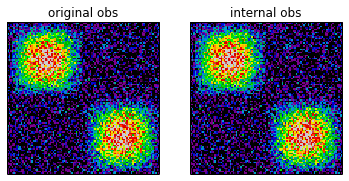

In [7]:
internal_obs = the_state.operators['Observations'].observations

cmap = plt.cm.spectral
cmap.set_bad ( '0.8' )

plt.subplot(1, 2, 1)
plt.imshow ( ndvi_obs, interpolation='nearest', vmin=0, vmax=1, cmap=cmap )
plt.xticks([])
plt.yticks([])
plt.title('original obs')
plt.subplot(1, 2, 2)
plt.imshow ( internal_obs, interpolation='nearest', vmin=0, vmax=1, cmap=cmap )
plt.xticks([])
plt.yticks([])
plt.title('internal obs')


Compare the values in the input array and the internal array for 5 randomly selected points.

In [8]:
import random

print "Element row, column | original value  | internal value  | equal?"
for i in xrange(5):
    test_row = random.randrange(0, rows)
    test_column = random.randrange(0, cols)

    original = ndvi_obs[test_row, test_column]
    internal = internal_obs[test_row, test_column]

    print "{:>11} ,{:^7}|{:>16} | {:>15} | {}".format(
            test_row, test_column, original, internal, (original==internal))


Element row, column | original value  | internal value  | equal?
         46 ,  59   | 0.0755506390828 | 0.0755506390828 | True
         38 ,  36   |  0.386262149508 |  0.386262149508 | True
         30 ,  98   |-0.0101785213188 | -0.0101785213188 | True
         32 ,  23   |  0.839077522886 |  0.839077522886 | True
         30 ,  65   |  0.111408384536 |  0.111408384536 | True


##Test 5.9

Verify that the saved state estimate array matches the internal estimate.
We use the example as set up above and optimise. An observation mask has been aplied leaving gaps in the observations given to eo_ldas, simulating clouds. The retrieved estimate is compared to that stored as an array in a pickle file. Each time optimize is run a new .pkl file is created with an auto generated name. This name can be checked in the file system and updated here. 

In [9]:
# First guess at state for optimization.
x_dict = {'magnitude': np.ones(rows*cols)*0.25}
retval = the_state.optimize(x_dict)

/usr/local/lib/python2.7/dist-packages/eoldas_ng-0.21-py2.7.egg/eoldas_ng/state.py:409: OptimizeWarning: Unknown solver options: factr, m, pgtol


In [14]:
# Read in the saved state array. The file name is automatically generated.
# This should be replaced by the latest filename
import cPickle as pickle
saved_array = pickle.load(open("eoldas_retval_20160120_164310_SH97R.pkl", 'rb'))

([], <a list of 0 Text yticklabel objects>)

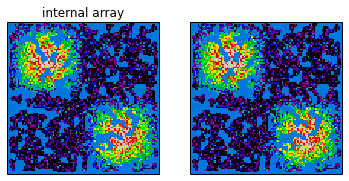

In [15]:
#Plot the two arrays
plt.subplot(1, 2, 1)
plt.imshow ( retval['real_map']['magnitude'], interpolation='nearest', vmin=0, vmax=1, cmap=cmap )
plt.xticks([])
plt.yticks([])
plt.title('internal array')
plt.subplot(1, 2, 2)
plt.imshow ( saved_array['real_map']['magnitude'], interpolation='nearest', vmin=0, vmax=1, cmap=cmap )
plt.xticks([])
plt.yticks([])

Compare the values in the input array and the internal array for 5 randomly selected points.

In [16]:
import random

print "Element row, column | internal value  | saved value  | equal?"
for i in xrange(5):
    test_row = random.randrange(0, rows)
    test_column = random.randrange(0, cols)

    internal = retval['real_map']['magnitude'][test_row, test_column]
    saved = saved_array['real_map']['magnitude'][test_row, test_column]

    print "{:>11} ,{:^7}|{:>16} | {:>15} | {}".format(
            test_row, test_column, internal, saved, (internal==saved))


Element row, column | internal value  | saved value  | equal?
         11 ,  96   |            0.25 |            0.25 | True
         39 ,  14   |            0.25 |            0.25 | True
         67 ,  27   |  0.178025120622 |  0.178025120622 | True
         27 ,  76   |            0.25 |            0.25 | True
         45 ,  72   | 0.0123952223968 | 0.0123952223968 | True


## Test 5.4

Confirm each element of the output array contains a float (is not empty) and is not Nan. Verify using the output array from the above tests.

In [17]:
for element in saved_array['real_map']['magnitude'].flatten():
    try:
        assert isinstance(element, float)
    except AssertionError:
        print element
        print type(element)
        
    try:
        assert element != np.nan
    except AssertionError:
        print element